In [26]:
from IPython.display import display
import mglearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
%matplotlib inline

### Decision trees

- 결정 트리는 분류에도 사용되고 회귀에도 사용된다.
- 결정 트리는 예/아니오를 이어나가면서 학습한다.
- 예/아니오에 적합한 질문을 해야한다.

- 아래 그림에 의하면 세 개의 특성을 이용하여 네 개의 클래스를 분류하는 머신러닝 모델을 만든 셈이 된다.

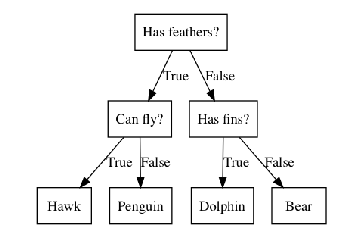

In [5]:
# brew install graphviz
mglearn.plots.plot_animal_tree()

##### 결정 트리 만들기

- 2개의 클래스를 분류하는 문제
- 한 클래스에 75개의 데이터 포인트가 존재함
- 이 데이터를 분류하는 것이 목적
- 데이터 자체의 특성을 보면 continuous한 x와 y의 (x,y)쌍으로 하나의 데이터가 구성됨
- 데이터 포인터를 구분하는 가장 쉬운 방법은 그냥 직선 하나를 긋는 것임
- 이 때, 직선은 horizontal 또는 vertical의 형태로만 가능

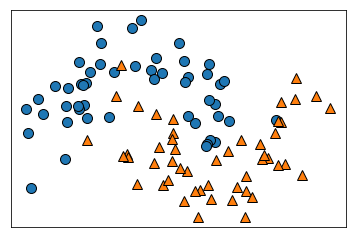

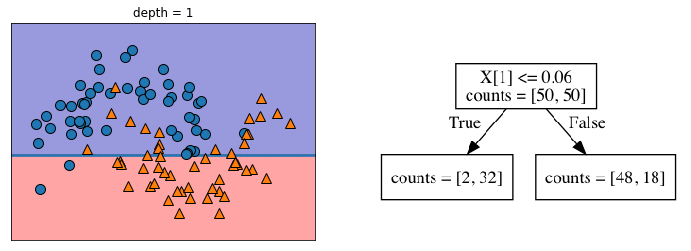

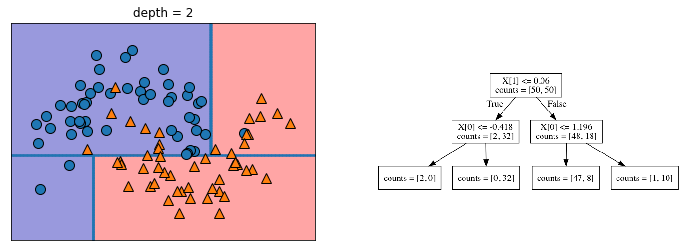

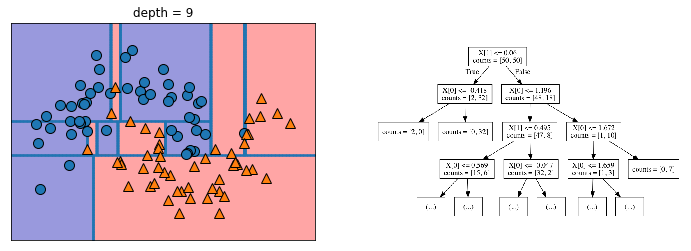

In [6]:
mglearn.plots.plot_tree_progressive()

- x축은 x[0]특성, y축은 x[1]특성
- 실수값이 0.0596이라는 분기의 기준값을 기준으로 결정경계가 x[1]에 그어진 결과가 첫 번째 그림
- 결정경계는 두 클래스를 가장 잘 나눈다고 판단한 결과로 생성됨
- 그러나 한 개의 직선만으로는 클래스를 나누는 것에 한계가 있을 수 있다. 따라서 더 많은 직선을 사용할 수 있다.
- 선 긋기를 반복할수록 나누어진 영역은 단 하나의 클래스에 대한 단수 혹은 복수의 데이터 포인트(들)을 갖는다.
- 그 때의 리프 노드를 순수 노드라고 부르며, 순수 노드 상태까지 왔다면 해당 트리는 과적합의 문제가 발생할 확률이 높은 트리이다. 마지막 그림이 이 상황을 표현하고 있다. 
- 과적합을 막는 방법은 크게 두 가지로 분류 가능하다. 
  - model생성시에 옵션을 주는 방법
  - 다른 모델을 사용하는 방법; 랜덤 포레스트(다음에 다룸)

##### 결정 트리의 복잡도 제어하기

- model생성시에 옵션을 주는 방법은 다음의 두 가지 방법이 가능하다.
  - Pre-pruning (사전 가지치기): 트리내 노드 생성을 사전에 중단 <--scikit-learn 에서 지원하는 것
  - Post-pruning (사후 가지치기) or Pruning: 트리의 노드를 만든 이후 데이터 포인트가 적은 노드를 삭제하거나 병합 --> 다루지 않음

In [7]:
from sklearn.tree import DecisionTreeClassifier

cancer = load_breast_cancer()
print("Shape of cancer data: {}".format(cancer.data.shape))

Shape of cancer data: (569, 30)


In [9]:
type(cancer)

sklearn.utils.Bunch

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


- max_depth는 질문의 개수를 의미

In [13]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


- 결과로 나온 정확도에 대하여 이해하기 위해 시각화가 필요

#### 결정 트리 분석(개략적 분석)

In [14]:
from sklearn.tree import export_graphviz
export_graphviz(tree, 
                out_file="tree.dot", 
                class_names=["malignant", "benign"],
                feature_names=cancer.feature_names, 
                impurity=False, 
                filled=True # 노드의 분류 클래스가 구분되도록 색이 칠해짐
)

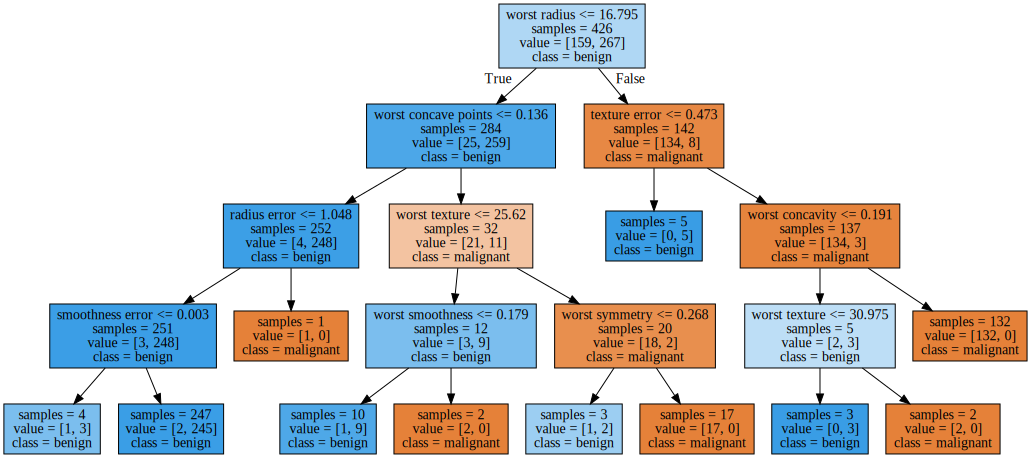

In [15]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

#### 
- 특성 중요도 (Feature Impotance)
  - 트리를 만드는 결정에 각 특성이 얼마나 중요한지를 평가
    - 0과 1사이의 숫자
    - 특성 중요도 전체의 합은 1
    - 0: 해당 특성이 분류에 전혀 활용되지 않았음
    - 1: 해당 특성이 분류를 하였고, 타깃 클래스를 정확하게 예측하였음을 나타냄

In [17]:
print("Feature importances:\n{}".format(tree.feature_importances_)) # 객체의 attribute으로 제공됨

Feature importances:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.01019737  0.04839825  0.          0.
  0.0024156   0.          0.          0.          0.          0.
  0.72682851  0.0458159   0.          0.          0.0141577   0.          0.018188
  0.1221132   0.01188548  0.        ]


- 유방암 데이터는 30개의 feature를 갖음

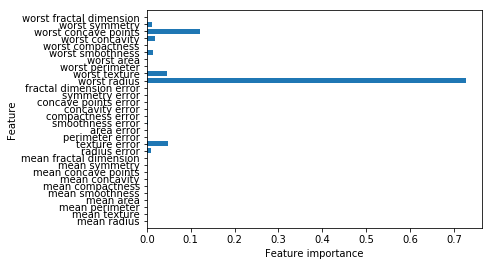

In [18]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.show()


plot_feature_importances_cancer(tree)

- 특성 중요도는 항상 양수이며, 어떤 클래스를 지지하는 지 알 수는 없다.

Feature importances: [ 0.  1.]


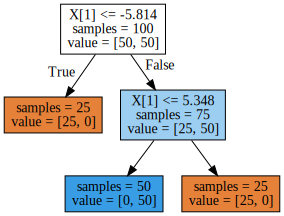

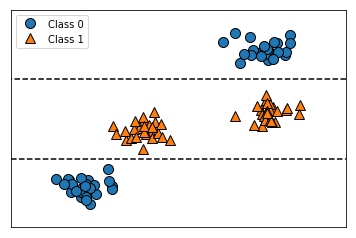

In [19]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

- Regression with DecisionTreeRegressor
- plt.semilogy()
  - Make a plot with log scaling on the `y` axis.

(333, 3)
   Unnamed: 0    date        price
0           0  1957.0  411041792.0
1           1  1959.0   67947725.0
2           2  1960.0    5242880.0


Text(0,0.5,'Price in $/Mbyte')

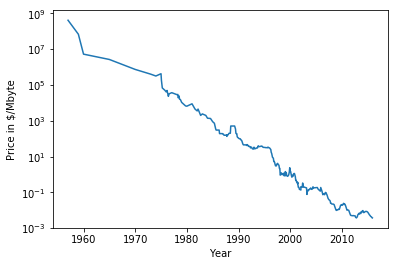

In [20]:
import os
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))
print(ram_prices.shape)
print(ram_prices.head(3))
plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

In [21]:
from sklearn.tree import DecisionTreeRegressor
# use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

print(data_train.head(3))

print()

print(data_test.head(3))

   Unnamed: 0    date        price
0           0  1957.0  411041792.0
1           1  1959.0   67947725.0
2           2  1960.0    5242880.0

     Unnamed: 0     date  price
202         202  2000.00   1.56
203         203  2000.08   1.48
204         204  2000.17   1.08


In [22]:
# predict prices based on date
# np.newaxis 으로 새로운 demension 생성
temp_X_train = data_train.date
print(temp_X_train[0])
print(temp_X_train[1])

print()

X_train = data_train.date[:, np.newaxis]
print(X_train.shape)
print(X_train[0])
print(X_train[1])

print()

# we use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)
print(y_train.shape)
print(y_train[0])
print(y_train[1])

1957.0
1959.0

(202, 1)
[ 1957.]
[ 1959.]

(202,)
19.834205451
18.0342492175


In [23]:
X_test = data_test.date[:, np.newaxis]
y_test = np.log(data_test.price)

In [27]:
tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# predict on all data
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# undo log-transform
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

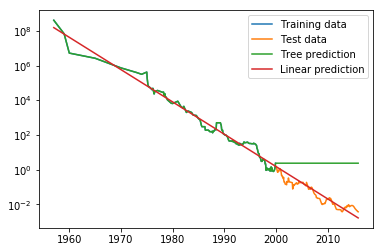

In [28]:
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
plt.legend()

- 위 트리 모델 훈련시에 모델 복잡도에 제한을 두지 않았음. --> 훈련 데이터를 완벽하게 예측함 --> 과적합
- 트리 모델을 사용한 테스트 시에 예측해야 할 값이 모델을 생성할 때 사용한 데이터 범위 밖에 존재할 때 트리는 적당하지 않음.

#### Strengths, weaknesses and parameters

- 트리 모델의 장점
  - 만들어진 모델을 쉽게 시각화하고 이해할 수 있음.
  - 각 특성은 개별적으로 다루어지기 때문에 특성의 정규화가 필요없음.
    - 각 특성의 스케일이 서로 달라도 문제 없이 모델 학습이 이루어짐.

- 트리 모델의 단점
  - 사전 가지치기를 사용할 지라도 종종 과대적합되는 경향이 있음. --> 해결책: Ensemble